<a href="https://colab.research.google.com/github/MohiteAkshay/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis_Using_Deep_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from fastai.text import *

In [141]:
df=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
df.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [142]:
df.isnull().sum() 

tweet_id    0
tweet       0
dtype: int64

In [143]:
test.isnull().sum()

tweet_id    0
tweet       0
dtype: int64

In [23]:
df.rename(columns={'sentiment':'target'}, inplace=True)

In [24]:
df.dropna(axis=0, inplace=True)

In [25]:
df.head()

,tweet_id,tweet,target
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [30]:
df['target'].value_counts()

1    4310
2    2382
0     456
3     125
Name: target, dtype: int64

In [149]:
test.shape

(1819, 2)

In [26]:
df.to_csv('tweet.csv', index=False)

In [17]:
path='/content'

In [145]:
text_enc= TextLMDataBunch.from_csv(path, valid_pct=0.2, test='test.csv',
                                   csv_name='tweet.csv', 
                                   text_cols='tweet', 
                                   label_cols='target')

In [147]:
text_enc

TextLMDataBunch;

Train: LabelList (5818 items)
x: LMTextList
xxbos 2 years of time saved every day by people qho use google maps & ' route around & ' feature # sxsw,xxbos xxup rt @mention # xxup sxsw i need the best android dev here . xxmaj html5 / xxup js issue need solving quickly . xxmaj handsome reward and love for grabs . # in,xxbos # xxup sxsw hire qualified and talented women consciously early on in # startups to achieve success - xxmaj google did !,xxbos @mention i 'm glad i do n't have an ipad 2 ... i think . # sxsw,xxbos xxup rt @mention xxmaj sound of xxmaj my xxmaj voice was shot exploiting xxmaj apple & & xxmaj best xxmaj buy 's 14-day return policy on imacs . xxmaj brilliant . # sxsw
y: LMLabelList
,,,,
Path: /content;

Valid: LabelList (1455 items)
x: LMTextList
xxbos xxmaj at # xxup sxsw ? ? xxunk @mention @mention @mention are there giving ipad demos of xxunk xxup xxunk ! xxmaj tweet them to check it out !,xxbos xxup rt @mention xxmaj learnt from @mention that there a

In [150]:
text_enc.train_ds[3]

(Text [   2   11   38  111 1159   38   78   71   74   50   24   42   60   38  171   12    9   10],
 EmptyLabel 0)

In [151]:
learn= language_model_learner(text_enc, AWD_LSTM, drop_mult=0.3)

In [152]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


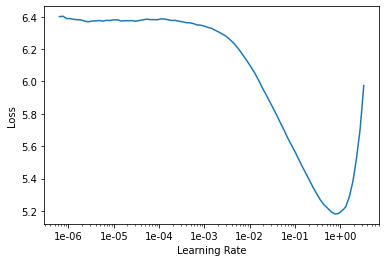

In [153]:
learn.recorder.plot()

In [154]:
learn.fit_one_cycle(10, 4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.914973,3.791260,0.307165,00:05
1,3.859684,3.119527,0.384911,00:05
2,3.256327,2.984895,0.413839,00:05
3,2.863582,2.915584,0.429777,00:05
4,2.567958,2.868850,0.447031,00:05
5,2.323200,2.826189,0.457612,00:05
6,2.111638,2.808463,0.466987,00:05
7,1.936927,2.794558,0.473437,00:05
8,1.814343,2.787626,0.476853,00:05
9,1.743405,2.787468,0.476830,00:05


In [155]:
learn.save('Encoder')

In [ ]:
learn.load('Encoder')

In [157]:
learn.unfreeze()

In [158]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.630654,2.754761,0.489933,00:07
1,1.565449,2.711920,0.506786,00:07
2,1.420686,2.733659,0.518795,00:07
3,1.246825,2.761081,0.524554,00:07
4,1.129240,2.784894,0.524509,00:07


In [159]:
TEXT='Iphone is costly '
N_WORDS=40
N_SENTENCES=2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Iphone is costly  up . Will not even get in for an ipad 2 . # SXSW xxbos Getting ready for my ipad 2 vs Android panel at # SXSW today ! All you need ?
Iphone is costly  out of the power of power needs on iphone vs Android vs The Heart at # sxsw . { link } xxbos RT @mention Google to Launch Major New Social


In [160]:
learn.save_encoder('fine_tuned')

In [161]:
#Classification
text= (TextList.from_csv(path=path, csv_name='tweet.csv', cols='tweet', vocab=text_enc.vocab)
                        .split_by_rand_pct(0.2 , seed= 30)
                        .label_from_df(cols='target')
                        .add_test(TextList.from_csv(path=path, csv_name='test.csv', cols='tweet'))
                        .databunch(bs=20))

In [162]:
text.show_batch()

text,target
"xxbos xxmaj ca n't believe i got in xxup and got a seat ! & ' xxmaj google & & xxmaj bing xxmaj on xxmaj website xxmaj ranking at xxup sxsw . & ' # xxup sxsw # qagb ( @mention xxmaj hilton , xxmaj salon j ) { link }",1
"xxbos xxmaj another xxup xxunk from # xxup sxsw : & ' xxmaj the xxmaj future of xxmaj reading xxmaj online xxmaj is xxmaj xxunk & & xxmaj sharing , xxmaj not xxmaj tablets ( xxmaj yet ) & ' | xxmaj fast xxmaj company - { link }",1
"xxbos xxup rt # xxup xxunk > xxmaj hey xxmaj austin , know a little about # iphone or # xxmaj android , love music & & wanna make $ 20 / hour during # xxup sxsw ? xxmaj please let me know . : xxmaj hey ...",1
"xxbos xxmaj which line at # xxup sxsw will be longer ? 3 / 11 at the temp xxmaj apple store for the ipad2 ? xxmaj or 3 / 14 at the xxmaj microsoft booth for xxup ie9 ? [ xxmaj yeah , right ! ] xxup :d",2
xxbos xxmaj xxunk in xxmaj austin . xxmaj spotted the xxmaj google xxmaj places xxmaj ads for # sxsw at the airport : & ' xxmaj the xxmaj xxunk xxmaj austin xxmaj pocket xxmaj guide & ' . xxmaj more like # xxmaj yelp than # xxunk,1


In [ ]:
learn=text_classifier_learner(text, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned')

In [164]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


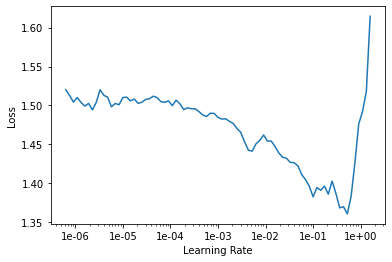

In [165]:
learn.recorder.plot()

In [166]:
learn.fit_one_cycle(3, 2e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.913640,0.836887,0.616919,00:06
1,0.877187,0.955867,0.621733,00:06
2,0.830676,0.936325,0.629299,00:06


In [168]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675673,0.776182,0.682944,00:07
1,0.710193,0.761371,0.684319,00:07
2,0.641454,0.799944,0.685007,00:07
3,0.550616,0.818132,0.687758,00:07
4,0.516426,0.810610,0.692572,00:07


In [170]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.488105,0.834425,0.683631,00:11
1,0.499188,0.851663,0.676754,00:12
2,0.449226,0.876812,0.688446,00:11
3,0.411238,0.904483,0.686382,00:11
4,0.423916,0.894557,0.689133,00:11


In [177]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.931322,0.856713,0.616231,00:15
1,0.818278,0.809470,0.633425,00:14
2,0.773593,0.756184,0.682944,00:15
3,0.651175,0.750894,0.694636,00:15
4,0.538369,0.791272,0.686382,00:15


In [183]:
preds, y = learn.get_preds(DatasetType.Test)